In [33]:
%pylab inline
import xarray as xr
from lib.multiscale import Averager, AdaptiveAverager, SVDAverager
from data import Wave

rc('savefig', dpi=120)

Populating the interactive namespace from numpy and matplotlib


# Summary and Conclusions

1. Automatic approaches to multiscale decomposition are effective for the Homogeneous SST simulations, but not for the Walker cell simulations.

2. The vertical velocity is very strong on synoptic scales in the Walker circulation simulation. This is because the planetary-scale circulatin has a very narrow ascent region and a very large descent region. This implies that the ansatz used by the IMMD model is violated in the 2D Walker cell simulation without rotation.
  
3. Using any of the proposed definitions of the multiscale decomposition the planetary-scale temporal anomalies are very small in both the Walker cell and homogeneous SST setups.

4. Wave-frame averaging methods can also be used to verify the MESD and IMMD models. If the waves are quasi-steady then the temporal average is given simply in terms of the spatial derivative of the wave-frame average.

5. I am currently running simulations with weak (latitude = 1.31N)

# Multiscale averaging methods

The objective is to decompose an input field into mesoscale, synoptic, and planetary scale patterns. This can be done in an interative fashion by first taking a meso-scale spatiotemporal average, followed by the larger scale averaging operations. Each averaging operation yields an averaged field and a perturbation field as shown in the graph below.

In [3]:
%%file multiscale.dot

digraph G  {
    rankdir=LR;
    
    sxt[label="Syn. X and T avg."];
    px[label="Pln. X avg."];
    pxt[label="Pln. X and T avg."];
    
    pert1[label="Residual"];
    pert2[label="Residual"];
    pert3[label="Residual"];

    "Data" ->  sxt -> px -> pxt;
    "Data" -> pert1;
        sxt -> "pert2"
        px -> "pert3";
 }

Overwriting multiscale.dot


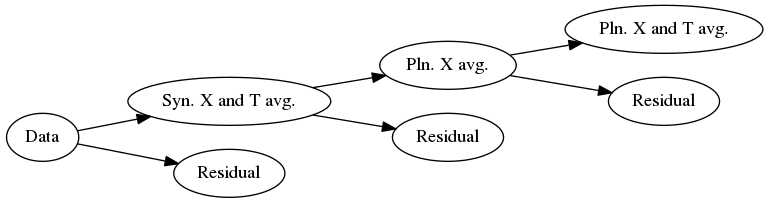

In [18]:
from IPython.display import Image
!dot -Tpng multiscale.dot > multiscale.png
# !dot -Tpng multiscale.dot 
Image("multiscale.png")


Unlike the IMMD model, the MESD model does not place emphasis on the larger spatial scale anomalies from the temporal mean, so the synoptic spatial and temporal averaging can be performed together. This procedure decomposes the input data in four fields:

1. (M) Residual from synoptic scale average ($x$ and $t$)
2. (S) Residual from planetary scale $x$ average, and previous.
3. (P) Residual from planetary scale $t$ average, and previous.
4. (PB) Planetary scale X and T average.

This is a simple and attractive procedure for multiscale decomposition, and it performs well for the homogeneous SST case, as will seen below. Unfortunately, it does not work well for the Walker cell simulation.

## Walker circulation


### SVD based decomposition

In the past report, I introduced a SVD based averaging procedure as an adaptive way to identify the planetary scale spatial patterns. Here, I show the results of the multiscale decomposition where P is obtained by the EOF approach, and the other averages are implemented using splines. It turns out that is not a suitable average for a variety of reasons. As can be seen here, the decomposition does a good job separating the scales for the horizontal velocity.

In [18]:
d = xr.open_dataset("wd/f8e7a/nondim.nc").sel(time=slice(100,200))
avg = SVDAverager.from_dataset(d)
w = SVDAverager.from_dataset(d).msdecomp(d.W)
u = SVDAverager.from_dataset(d).msdecomp(d.U)

w_plot = w.isel(z=15).compute()

/home/ndb245/anaconda3/lib/python3.6/site-packages/dask/array/core.py:457: RuntimeWarning: overflow encountered in true_divide
  o = func(*args, **kwargs)


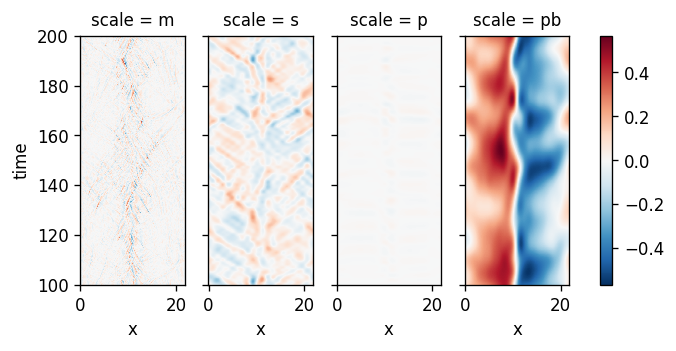

In [14]:
u.isel(z=10).plot(col='scale', figsize=(6,3));

Unfortunately, it does not work very well for the vertical velocity $w$, as can be seen here:

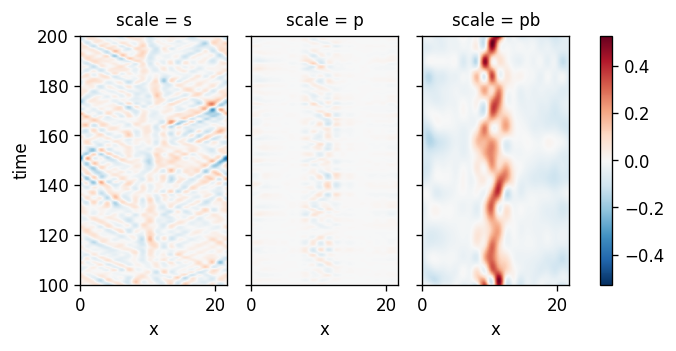

In [22]:
w_plot.sel(scale=['s','p', 'pb']).plot(col='scale', figsize=(6,3));

The SVD based averaging does not work well for $H$ or $W$  because the variability in these fields is dominated by synoptic scale waves in the center of the domain. Another problem with the SVD based averaging, is that different averaging operators are used for the different fields. Therefore, eddy flux quantities are not well defined with the SVD average. The best way around this is probably to use the SVDs to help choose the best knot locations for the splines.

### Adapative spline based planetary average

In the past report, the knots (discontinuities) used for the spline basis were equally spaced, which was a problem because the spatial scales of the Walker circulation are smaller in the center of the domain. In this section, we try to ameliorate this problem, and the issues with the EOF approach by judiciously increasing the knots in the center of the domain. Specifically, we let the knots be given by $t = \{0, .25, .375,  .4375, .5, .5625, .625, .75, 1\}$. The spacing of these knots is highest in the center and increases towards the boundaries.


We evaluate the performance of this spline basis by seeing how well it can capture the mean circulation at the height indivated by the horizontal line in the plot below.

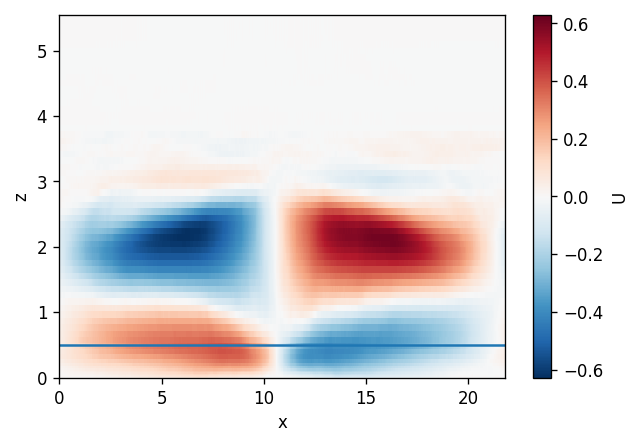

In [28]:
d.U.mean('time').plot()
axhline(.5)
uz2 = d.U.mean('time').sel(z=.5, method='nearest')

As can be seen below,  this set of knots is able to capture the circulation very well.

In [29]:
from scipy.interpolate import LSQUnivariateSpline



def _mkxknots(x):
    L = float(x[-1]*2 - x[-2])
    L2 = L/2
    knots = [0, 1*L/4, L2- L/8, L2 - L/16, L2, L2 + L/16, L2 + L/8, L * 3/4, L]
    return np.array(knots)


# plot knots locations
for k in _mkxknots(uz2.x):
    axvline(k, ls='--', c='.7')
    
spl = LSQUnivariateSpline(uz2.x.values, uz2.values, _mkxknots(uz2.x)[1:-1])
plot(uz2.x, spl(uz2.x), label='u')
plot(uz2.x, uz2, label='spline')

plt.title("$u$ at $z=0.49$")

legend()

How does this perform as a planetary scale average for other fields?

In [30]:
avg = AdaptiveAverager.from_dataset(d)

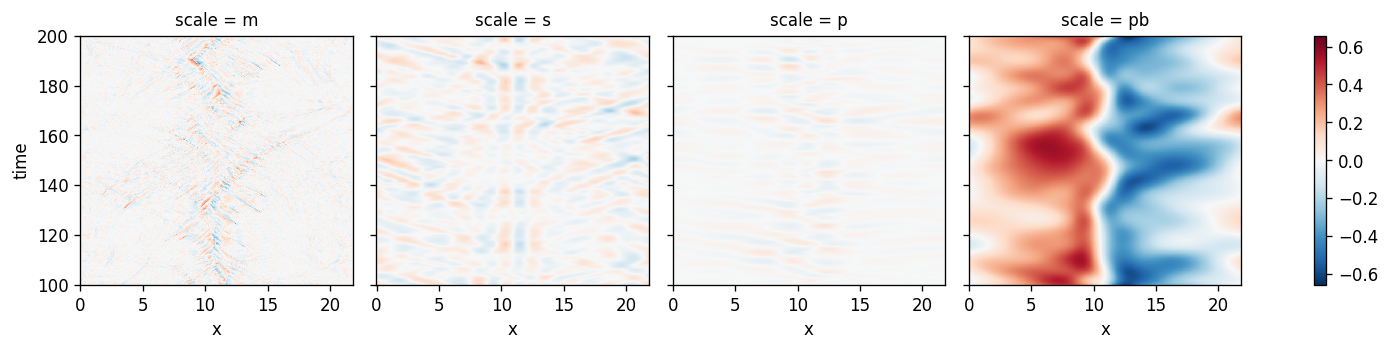

In [31]:
avg.msdecomp(d.U)\
   .isel(z=10).plot(col='scale')

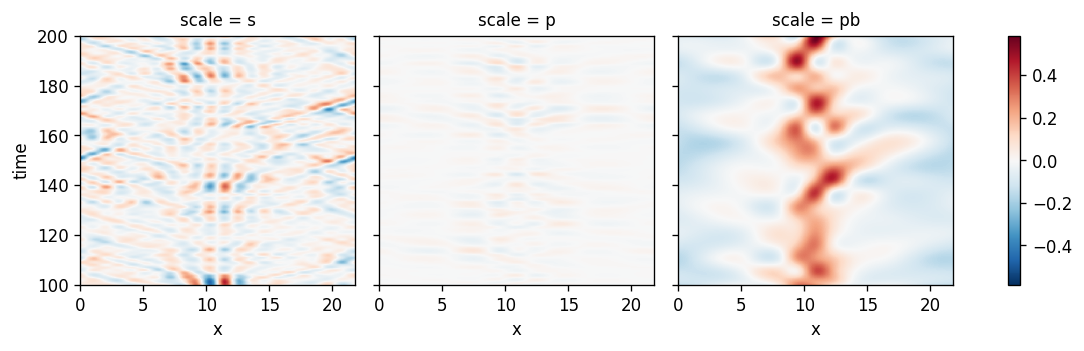

In [32]:
avg.msdecomp(d.W)\
   .isel(z=20,scale=slice(1,None)).plot(col='scale')

This techinque appears to give similar results to the EOF technique.

### Wave-frame averaging

The the above automatic averaging approaches are relatively unsuccesful because the scales are not actually well separated in the Walker cell simulations. Both the EOF and spline based averaging procedures are senstive to the number of EOFs and/or the bandwidths of the spline basis. 


The automatic decompositions fails on the Walker circulation simulations, so the
alternative approach is manually identify waves of different scales in the
simulation.
Once a representative mesoscale and synoptic scale waves have been identified, the
wave-frame average defines a suitable spatio-temporal average, which can be used
to verify the IMMD equations.
The coordinates in frame which is moving with a velocity of $c$ are defined by
$$ \tilde{x} = x -c t -\text{ and } \tilde{t} = t .$$
Therefore, the chain rule gives
$$\partial_t = \partial_{\tilde{t}} - c \cdot \partial_{\tilde{x}},$$
which can be used in the multiscale equations.
If the wave is quasi-stationary, the wave-frame time-derivative, which is not an
easily computed value, vanishes to that $\partial_t = -c
\cdot \partial_{\tilde{x}}.$
This formula can be computed easily by taking spatial derivatives of the
wave-frame average.


In [69]:
import yaml
config = yaml.load(open("config.yaml"))

d = xr.open_dataset("wd/f8e7a/nondim.nc")
waves = config['runs']['f8e7a']['waves']
wavea = Wave(waves['A'])

In the section, I plot some wave averages for the strong propagating disturbances in the center of the domain. The plot below shows the overall variablity of the horizontal winds in the Walker cell simulation.

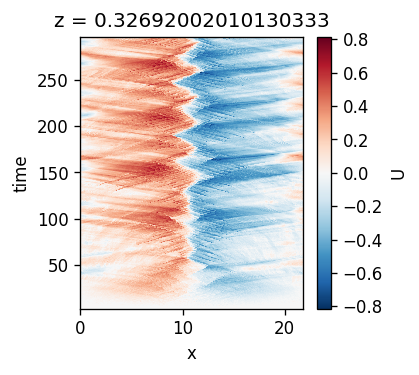

In [39]:
d.U.isel(z=10).plot(figsize=(3,3))

The following plot zooms in on one of these large waves.

In [78]:
plt.figure(figsize=(10,4))
plt.subplot(121)
wavea.plot_xt(d.U.isel(z=10), vmin=-1, vmax=1, cmap='RdBu_r')
plt.subplot(122)
wavea.average(d.U)[0].sel(z=slice(0,pi)).plot.contourf(levels=21, vmin=-1, vmax=1, cmap='RdBu_r')
plt.title("Wave frame average")
plt.tight_layout()

From these plots it is clear that the wave is not just a perturbation to a large-scale climatology, but is rather a wholesale shifting of the planetary scale wind patterns. Moreover, the convergence due to this disturbance is concentrated in a very narrow cross section as can be seen by plotting the wave-frame vertical velocity. The ascent region in the climatolgy appears wider than it actually is because that plot averages over the entire propagation length of these waves.

In [82]:
plt.figure(figsize=(5,4))
avg,_ = wavea.average(d.W)
avg.sel(z=slice(0,pi)).plot()

This analysis of the variability of the Walker cell simulation indicates that the IMMD framework is not well suited to the analysis of two dimensional and rotation free simulations forced by large oceanic temperature gradients. This is for two reasons:

1. The IMMD ansatz requires that $W= O(\epsilon)$ on planetary and synoptic scales, which is clearly not the case here.
2. The scales of motion are drastically different inside and outside the warm-pool in this simulation. The "planetary" circulation actually consists of a mesoscale (and propagating) region of ascent and large-scale descent region.

## Homogeneous SST

For the case with homogeneous SST, a spline-based decomposition works well, as can be seen in the output below.

In [ ]:
d = xr.open_dataset("wd/8aa7b/nondim.nc", chunks={'time':500})

avg = Averager.from_dataset(d, l_s=2.0)
u_ms = avg.msdecomp(d.U)
u_ms_10 = u_ms.isel(z=10).compute()

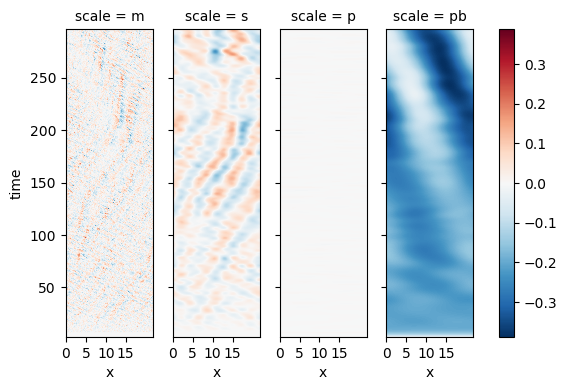

In [21]:
fg= u_ms_10.plot(col='scale',figsize=(6,4))
for ax in fg.axes.flat:
    ax.set_xticks([0,5,10,15])

From the left to the right, these plots are correspond to the M, S, P, PB fields defined in the list above. The planetary-scale averages (PB) show a strong westward propagating disturbance which increases in amplitude, and the synoptic scale residuals (S) mainly consist of eastward propagating waves.

# Simulations with weak rotation

The coriolis force is given by $f = 2 \Omega \sin(\theta)$, where $\theta$ is the latitude. This quantity has units time, so plotting the time scale associated with rotation is helpful. The latitude where the rotational time scale satisfies $f = \epsilon / T_E$ is $\theta = \SI{1.31}{\deg N}$.

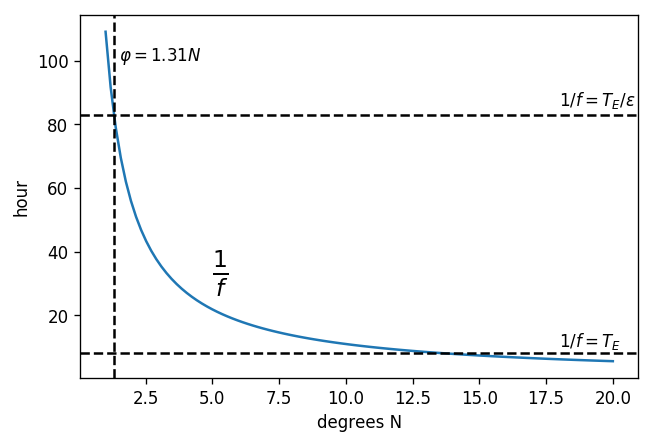

In [124]:
def plot_cori():
    from metpy.constants import earth_avg_angular_vel
    from metpy.units import units
    from scipy.optimize import fsolve
    Q_ = units.Quantity
    lat = r_[1:20:101j]
    def cori(lat):
        return (2 *earth_avg_angular_vel * sin(lat*2*pi/360)).to("1/hr")


    order_eps_lat = fsolve(lambda x: cori(x).magnitude -  1/8.3/10,1)

    plot(lat, 1/cori(lat), label=r'$\frac{1}{f}$')

    
    plt.text(18, 86, "$1/f =T_E / \epsilon$")
    plt.text(18, 10, "$1/f =T_E$")
    plt.text(1.5, 100, fr'$\varphi = {order_eps_lat[0]:.2f} N$')
    plt.text(5.0, 30, r"$\frac{1}{f}$", fontsize=20)
    axvline(1.31, ls='--', c='k')
    xlabel(r"degrees N")
    ylabel(r"hour")
    axhline(83, ls='--', c='k')
    axhline(8.3, ls='--', c='k')
#     legend()
plot_cori()

At this latitude, the coriolis force is $O(\epsilon)$, and the first order constraint that $\tilde{f} U(X,T) = -P_Y = 0$ in the IMMD model is no longer required. This contraint is the reasons we saw such strong meridional winds in the Walker circulation experiments at 6N and 10N. In fact, as can be seen in the plot above, the strength of the rotation is very similar between 6N and 10N.